In [ ]:
#! pip install lime

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import lime.lime_tabular
import sklearn.tree
import sklearn.ensemble
np.random.seed(1)

In [4]:
# 3 feature case
# feature_names = ["x1", "x2", "x3"]
# target_names = ["0", "1"]
# simple_almost_identical_X = np.array([
#     #x1 x2 x3
#     [0, 0, 0],
#     [0, 1, 1],
#     [1, 0, 0],
#     [1, 1, 1],
# ])
# simple_almost_identical_y = np.array([
#     0,
#     0,
#     0,
#     1
# ])
#y = np.append(simple_almost_identical_X, simple_almost_identical_y.reshape(4,1), axis=1)

In [6]:
# #plt.scatter(simple_almost_identical_X, simple_almost_identical_y)

# # Create a figure and a 3D axes
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# # Plot the scatter plot
# ax.scatter(simple_almost_identical_X[:,0], simple_almost_identical_X[:,1], simple_almost_identical_X[:,2], c=simple_almost_identical_y)

# # Set labels for the axes
# ax.set_xlabel('x1')
# ax.set_ylabel('x2')
# ax.set_zlabel('x3')

# # Show the plot
# plt.show()

In [7]:
# def special_and_classifier(inputs):
#     results = []
#     print(len(inputs), inputs)
#     for input in  inputs:
#         x1, x2, x3 = input
#         y_pred = x1 + x2
#         if y_pred < 2:  
#             results.append([0.99, 0.01]) #state 0
#         elif x3 != x2:
#             results.append([0.01, 0.99]) #state 1
#         else:
#             results.append([0.01, 0.99]) #state 1
#     return np.array(results)

## Idea: Local explanations should identify importance locally

**Sanity check: If a feature only gives information for a limited set of points, a local explanation should identify that feature as important only within that set.**

Note: The location of the limited set should not be correlated with the decision boundary of the feature that does not provide additional information. It is likely that a local explanation will learn this relationship.

Example Procedure: 

Test explanations on a two feature model, make the output class depend only on x1 except between x1 values of 1 and 2. Between those values, the output is dependant on x2.

The local explaination should identify x2 as important in that region, but not the other regions.

### Example Where Location of Limited Set is Correlated with x1

#### Create Sample Dataset

In [19]:
# 2 feature case
# idea: x2 is only informative for 1 < x1 <= 2

# create points that cover the feature region, no info added by x2
feature_names = ["x1", "x2"]
target_names = ["0", "1"]
x1 = np.append(np.arange(0,6,0.1), np.arange(0,6,0.1))
x2 = np.append(np.zeros(len(np.arange(0,6,0.1))), np.ones(len(np.arange(0,6,0.1))))
y = np.zeros(x1.shape)
y[3 < x1] = 1

# switch y label in specific region (1<x1<=2) only where x2=1
y[(x2==1)&(1<x1)&(x1<=2)] = 1

correlation_X = np.append(x1.reshape(len(x1),1),x2.reshape(len(x1),1),axis=1)
correlation_y = y


Text(0, 0.5, 'x2')

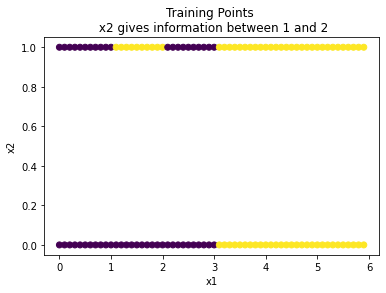

In [20]:
plt.scatter(
        x=correlation_X[:,0], 
        y=correlation_X[:,1], 
        c=correlation_y
    )
plt.title("Training Points \n x2 gives information between 1 and 2")
plt.xlabel("x1")
plt.ylabel("x2")

#### "Train" a Model on the Dataset

To ensure our model learns the features in the dataset, we can code them into a function directly with decision rules. While this model isn't "trained", its outputs will function the same way a black box model's outputs would.

In [21]:
def sanity_classifier_correlation(inputs):
    """
    Acts as a decision tree. Is informed by x2 only between 1<x1<=2 
    """
    #custom decisison tree
    results = []
    print(len(inputs), inputs)
    for input in  inputs:
        x1, x2 = input
        if (1 < x1) and (x1 <= 2) and (x2 > 0.5):
            results.append([0.01, 0.99]) #state 1
        elif (1 < x1) and (x1 <= 2) and (x2 <= 0.5):
            results.append([0.99, 0.01]) #state 0
        elif x1 < 3:  
            results.append([0.99, 0.01]) #state 0
        else:
            results.append([0.01, 0.99]) #state 1
    return np.array(results)


#### Create and Examine Local Explainations

In [26]:
# initialize an instance of LIME
explainer_correlation = lime.lime_tabular.LimeTabularExplainer(
        correlation_X, feature_names=feature_names, 
        class_names=target_names, discretize_continuous=True
    )

In [27]:
point_of_interest = np.array([1.5,0])
exp = explainer_correlation.explain_instance(
        point_of_interest, sanity_classifier_correlation, num_features=2
    ) #see if i can get back kernel weights

exp.show_in_notebook(show_table=True, show_all=False)

# Extract feature weights from the explanation
feature_weights = exp.as_list()

# Display feature importance
print("LIME Feature Importance:")
for feature, weight in feature_weights:
    print(f"{feature}: {weight}")

5000 [[1.5        0.        ]
 [3.57033408 0.        ]
 [0.64369992 0.        ]
 ...
 [2.40332358 0.        ]
 [2.02464246 0.        ]
 [1.98629048 0.        ]]


LIME Feature Importance:
1.48 < x1 <= 2.95: -0.5406137924756679
x2 <= 0.00: -0.1823397672437765


When examining an instance where we know that x2 decided the label 0, we find that LIME said x2 was less significant than x1.

In [28]:
point_of_interest = np.array([1.5,1])
exp = explainer_correlation.explain_instance(
        point_of_interest, sanity_classifier_correlation, num_features=2
    ) #see if i can get back kernel weights

# Extract feature weights from the explanation
feature_weights = exp.as_list()

# Display feature importance
print("LIME Feature Importance:")
for feature, weight in feature_weights:
    print(f"{feature}: {weight}")

5000 [[1.5        1.        ]
 [4.3988493  1.        ]
 [0.23480452 1.        ]
 ...
 [3.87830694 0.        ]
 [5.68321502 1.        ]
 [2.55227916 1.        ]]
LIME Feature Importance:
1.48 < x1 <= 2.95: -0.5043345171327028
0.50 < x2 <= 1.00: 0.1545672539927713


For the corresponding instance (x2=1 decided the label 1), we find the same. That LIME said x2 was less significant than x1.

**Important Note:** However, without examining the suggested importance of x2 in other regions, we have no frame of reference to determine if the importance is meaningfully different.

#### Examine Explanations Throughout the Feature Space

Below we plot importance values for all data points in the feature space. The local explainer should identify x2 as more important in the region where it is indeed more important (1<x<=2)

5000 [[0.         0.        ]
 [4.56534819 1.        ]
 [0.13769799 1.        ]
 ...
 [0.97749673 0.        ]
 [5.61261878 0.        ]
 [0.46429184 0.        ]]
5000 [[0.01       0.        ]
 [2.25981738 1.        ]
 [5.60419471 1.        ]
 ...
 [2.58424178 0.        ]
 [4.21493312 1.        ]
 [1.46697765 0.        ]]
5000 [[0.02       0.        ]
 [0.51665857 0.        ]
 [3.81487506 0.        ]
 ...
 [1.95338833 0.        ]
 [3.23715277 1.        ]
 [2.5479523  0.        ]]
5000 [[0.03       0.        ]
 [2.35726376 1.        ]
 [4.82019156 0.        ]
 ...
 [5.43981921 0.        ]
 [4.64026152 1.        ]
 [4.87313886 0.        ]]
5000 [[0.04       0.        ]
 [5.51682884 0.        ]
 [2.17325145 1.        ]
 ...
 [0.37149108 1.        ]
 [1.96567211 0.        ]
 [1.7988496  1.        ]]
5000 [[0.05       0.        ]
 [3.44577309 1.        ]
 [2.72233571 0.        ]
 ...
 [2.05013631 1.        ]
 [2.35565852 0.        ]
 [4.64134586 0.        ]]
5000 [[0.06       0.        ]
 [0.

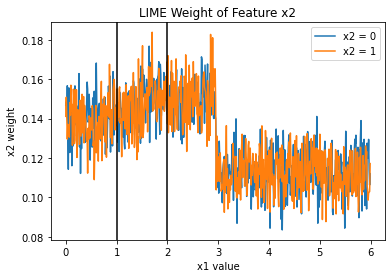

In [39]:
def plot_importance(chosen_feature, explainer, sanity_classifier):
    global plot_weights
    plot_weights = []
    x1_range = np.arange(0,6,0.01)
    for x2_val in [0,1]:
        xi_weights = []
        for x1_val in x1_range:
            point_of_interest = np.array([x1_val,x2_val])
            exp = explainer.explain_instance(
                    point_of_interest, sanity_classifier, num_features=2
                )
            feature_weights = exp.as_list()
            for feature, weight in feature_weights:
                if chosen_feature in feature:
                    xi_weights.append(weight)
        plot_weights.append(xi_weights)
    
    plt.plot(x1_range, np.abs(plot_weights[0]))
    plt.plot(x1_range, np.abs(plot_weights[1]))
    plt.axvline(x=1, color="black", ymin=0, ymax=1, linestyle="-")
    plt.axvline(x=2, color="black", ymin=0, ymax=1, linestyle="-")
    plt.title(f"LIME Weight of Feature {chosen_feature}")
    plt.xlabel('x1 value')
    plt.ylabel(f'{chosen_feature} weight')
    plt.legend(['x2 = 0', 'x2 = 1'])

plot_importance("x2", explainer_correlation, sanity_classifier_correlation)
plt.show()

It appears that LIME identified that x2 was more important when x1 was less than three, which does accurately capture a pattern we've encoded, but doesn't capture the true region of feature importance.

We add a second region of feature significance to remove the correlation between the x1 value and the relevance of x2. 

### Example Where Location of Limited Set is NOT Correlated with x1

#### Create Sample Dataset

Text(0, 0.5, 'x2')

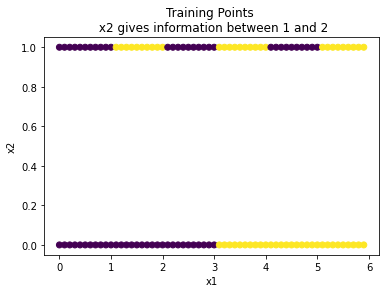

In [30]:
# 2 feature case
# idea: x2 is informative for 1 < x1 <= 2 and 4 < x1 <= 5

# create points that cover the feature region, no info added by x2
feature_names = ["x1", "x2"]
target_names = ["0", "1"]
x1 = np.append(np.arange(0,6,0.1), np.arange(0,6,0.1))
x2 = np.append(np.zeros(len(np.arange(0,6,0.1))), np.ones(len(np.arange(0,6,0.1))))
y = np.zeros(x1.shape)
y[3 < x1] = 1

# switch y label in specific region (1<x1<=2) only where x2=1
y[(x2==1)&((1<x1)&(x1<=2))] = 1
y[(x2==1)&((4<x1)&(x1<=5))] = 0

no_correlation_X = np.append(x1.reshape(len(x1),1),x2.reshape(len(x1),1),axis=1)
no_correlation_y = y

plt.scatter(
        x=no_correlation_X[:,0], 
        y=no_correlation_X[:,1], 
        c=no_correlation_y
    )
plt.title("Training Points \n x2 gives information between 1 and 2")
plt.xlabel("x1")
plt.ylabel("x2")

#### "Train" a Model on the Dataset

In [33]:
def sanity_classifier_uncorrelated(inputs):
    """
    Acts as a decision tree. Is informed by x2 only between 1<x1<=2 
    """
    #custom decisison tree
    results = []
    print(len(inputs), inputs)
    for input in  inputs:
        x1, x2 = input
        # x2 significant region 1
        if (1 < x1) and (x1 <= 2) and (x2 > 0.5):
            results.append([0.01, 0.99]) #state 1
        elif (1 < x1) and (x1 <= 2) and (x2 <= 0.5):
            results.append([0.99, 0.01]) #state 0
        # x2 significant region 2
        elif (4 < x1) and (x1 <= 5) and (x2 > 0.5):
            results.append([0.99, 0.01]) #state 0
        elif (4 < x1) and (x1 <= 5) and (x2 <= 0.5):
            results.append([0.01, 0.99]) #state 1
        # everywhere else
        elif x1 < 3:  
            results.append([0.99, 0.01]) #state 0
        else:
            results.append([0.01, 0.99]) #state 1
    return np.array(results)


#### Create and Examine Local Explainations

In [34]:
# initialize an instance of LIME
explainer_uncorrelated = lime.lime_tabular.LimeTabularExplainer(
        no_correlation_X, feature_names=feature_names, 
        class_names=target_names, discretize_continuous=True
    )

In [35]:
point_of_interest = np.array([1.5,0])
exp = explainer_uncorrelated.explain_instance(
        point_of_interest, sanity_classifier_uncorrelated, num_features=2
    ) #see if i can get back kernel weights

exp.show_in_notebook(show_table=True, show_all=False)

# Extract feature weights from the explanation
feature_weights = exp.as_list()

# Display feature importance
print("LIME Feature Importance:")
for feature, weight in feature_weights:
    print(f"{feature}: {weight}")

5000 [[1.5        0.        ]
 [0.45813199 1.        ]
 [4.64815763 0.        ]
 ...
 [3.16456616 1.        ]
 [5.1850006  1.        ]
 [2.56797844 0.        ]]


LIME Feature Importance:
1.48 < x1 <= 2.95: -0.47621650302684254
x2 <= 0.00: -0.048566704816082


When examining an instance where we know that x2 decided the label 0, we again find that LIME said x2 was less significant than x1.

In [36]:
point_of_interest = np.array([1.5,1])
exp = explainer_uncorrelated.explain_instance(
        point_of_interest, sanity_classifier_uncorrelated, num_features=2
    ) #see if i can get back kernel weights

# Extract feature weights from the explanation
feature_weights = exp.as_list()

# Display feature importance
print("LIME Feature Importance:")
for feature, weight in feature_weights:
    print(f"{feature}: {weight}")

5000 [[1.5        1.        ]
 [5.3053674  0.        ]
 [4.10552685 1.        ]
 ...
 [0.63693766 0.        ]
 [5.0870882  1.        ]
 [2.54149799 1.        ]]
LIME Feature Importance:
1.48 < x1 <= 2.95: -0.41880366937914976
0.50 < x2 <= 1.00: 0.026280594631819552


For the corresponding instance of x1 we again find the same.

#### Examine Explanations Throught The Feature Space

5000 [[0.         0.        ]
 [3.90069289 0.        ]
 [3.12996723 0.        ]
 ...
 [4.10380625 0.        ]
 [1.58072267 0.        ]
 [2.0517367  1.        ]]
5000 [[0.01       0.        ]
 [5.37026592 0.        ]
 [3.78746696 1.        ]
 ...
 [0.28114984 0.        ]
 [4.59811994 1.        ]
 [5.20820362 0.        ]]
5000 [[0.02       0.        ]
 [2.58694961 0.        ]
 [1.47661822 1.        ]
 ...
 [5.02087235 1.        ]
 [5.72549686 0.        ]
 [2.4478412  0.        ]]
5000 [[0.03       0.        ]
 [0.59005879 0.        ]
 [3.79840548 0.        ]
 ...
 [1.64698913 1.        ]
 [3.97373778 1.        ]
 [5.60980506 1.        ]]
5000 [[0.04       0.        ]
 [0.505848   1.        ]
 [3.87857238 0.        ]
 ...
 [3.75988148 0.        ]
 [1.2419471  0.        ]
 [5.03987629 1.        ]]
5000 [[0.05       0.        ]
 [1.83691584 1.        ]
 [2.2442329  0.        ]
 ...
 [5.4757407  1.        ]
 [1.66632869 1.        ]
 [2.79199987 0.        ]]
5000 [[0.06       0.        ]
 [0.

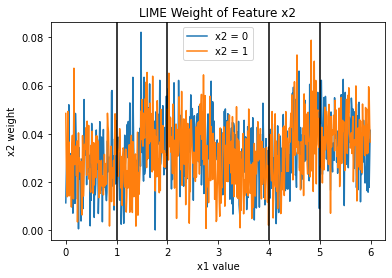

In [40]:
plot_importance("x2", explainer_uncorrelated, sanity_classifier_uncorrelated)
plt.axvline(x=4, color="black", ymin=0, ymax=1, linestyle="-")
plt.axvline(x=5, color="black", ymin=0, ymax=1, linestyle="-")
plt.show()

When the correlation was removed, LIME found no difference in the local importance of x2. Therefore in this case, LIME was unable to identify the local importance of a causal feature.

### Future Directions for this Sanity Check

- Look at how relative importance changes when varying the size of the density kernel.
- Test on even simpler tabular examples.
- Train a true black box model on a dataset that requires the features be learned and perform the sanity check.

### General Procedure Summary

1. duplicate one column, 
2. add points for specific values of that column where the output is switched (create counterexamples so model has to learn duplicate matters for a region)
3. determine if explainer identifies the duplicate feature as important for the region (it has to be b/c its only way to differentiate in the region)

In our example, LIME uncovered a correlation, that x2 was only important in the region where x1 was 0. However, LIME did not identify the local importance of x2.